In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sqlite3
from scipy.stats import ttest_ind # for hypothesis testing
import scipy.stats as stats
warnings.filterwarnings('ignore')

In [16]:
#creating database connection
con = sqlite3.connect('inventory.db')

#fetching vendor summary data
df = pd.read_sql_query("SELECT * FROM vendor_sales_summary", con)
df.head()

,VendorNumber,VendorName,Brand,Description,PurchasePrice,Volume,ActualPrice,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesDollars,TotalSalesQuantity,TotalSalesPrice,TotalExciseTax,FreightCost,GrossProfit,ProfitMargin,StockTurnover,SalesToPurchaseRatio
0,1128,BROWN-FORMAN CORP,1233,Jack Daniels No 7 Black,26.27,1750.0,36.99,145080,3811251.60,5.101920e+06,142049.0,672819.31,260999.20,68601.68,1290667.91,25.297693,0.979108,1.338647
1,4425,MARTIGNETTI COMPANIES,3405,Tito's Handmade Vodka,23.19,1750.0,28.99,164038,3804041.22,4.819073e+06,160247.0,561512.37,294438.66,144929.24,1015032.27,21.062810,0.976890,1.266830
2,17035,PERNOD RICARD USA,8068,Absolut 80 Proof,18.24,1750.0,24.99,187407,3418303.68,4.538121e+06,187140.0,461140.15,343854.07,123780.22,1119816.92,24.675786,0.998575,1.327594
3,3960,DIAGEO NORTH AMERICA INC,4261,Capt Morgan Spiced Rum,16.17,1750.0,22.99,201682,3261197.94,4.475973e+06,200412.0,420050.01,368242.80,257032.07,1214774.94,27.139908,0.993703,1.372493
4,3960,DIAGEO NORTH AMERICA INC,3545,Ketel One Vodka,21.89,1750.0,29.99,138109,3023206.01,4.223108e+06,135838.0,545778.28,249587.83,257032.07,1199901.61,28.412764,0.983556,1.396897


### **Exploratory Data Analysis**

Previously we examined various tables in the database to identify key variables, understand their relationship, and determine which ones should be included in the final analysis.
In this phase of EDA, we will analyze the resultant table to gain insights into the distribution of each column. This will help us understand data patterns, identify anomalies and ensure data quality before proceeding with further analysis.

In [17]:
# summary statistics
df.describe().T
# transposing the dataframe

,count,mean,std,min,25%,50%,75%,max
VendorNumber,10692.0,1.065065e+04,18753.519148,2.00,3951.000000,7153.000000,9552.000000,2.013590e+05
Brand,10692.0,1.803923e+04,12662.187074,58.00,5793.500000,18761.500000,25514.250000,9.063100e+04
PurchasePrice,10692.0,2.438530e+01,109.269375,0.36,6.840000,10.455000,19.482500,5.681810e+03
Volume,10692.0,8.473605e+02,664.309212,50.00,750.000000,750.000000,750.000000,2.000000e+04
ActualPrice,10692.0,3.564367e+01,148.246016,0.49,10.990000,15.990000,28.990000,7.499990e+03
TotalPurchaseQuantity,10692.0,3.140887e+03,11095.086769,1.00,36.000000,262.000000,1975.750000,3.376600e+05
TotalPurchaseDollars,10692.0,3.010669e+04,123067.799627,0.71,453.457500,3655.465000,20738.245000,3.811252e+06
TotalSalesDollars,10692.0,4.223907e+04,167655.265984,0.00,729.220000,5298.045000,28396.915000,5.101920e+06
TotalSalesQuantity,10692.0,3.077482e+03,10952.851391,0.00,33.000000,261.000000,1929.250000,3.349390e+05
TotalSalesPrice,10692.0,1.879378e+04,44952.773386,0.00,289.710000,2857.800000,16059.562500,6.728193e+05


1. Gross profit ---- Min is -₹52,002 – means loss is happening for some products.
2. ProfitMargin ---- Min is -inf, mean is also -inf, and std is NaN – this metric is likely miscalculated for rows where sales = 0 or purchase = 0.
3. We can see 0 for totalsalesquantity, which means the product was bought but they did not sell it.
4. every column has 10692 entires, which means no missing data.

5. PurchasePrice ---- Min is ₹0.36 and max is ₹5681 – very wide range, some items are super cheap, others very expensive.
6. ActualPrice ---- Ranges from ₹0.49 to ₹7499 – again, wide pricing.
7. TotalPurchaseDollars ---- Huge spread (₹0.71 to ₹3.8 million) – indicates some vendors/brands buy in bulk.
8. SalesToPurchaseRatio/StockTurnover ----- Some values are 0 – sales not happening after purchase; some go as high as 3.5 – good turnover for some items.

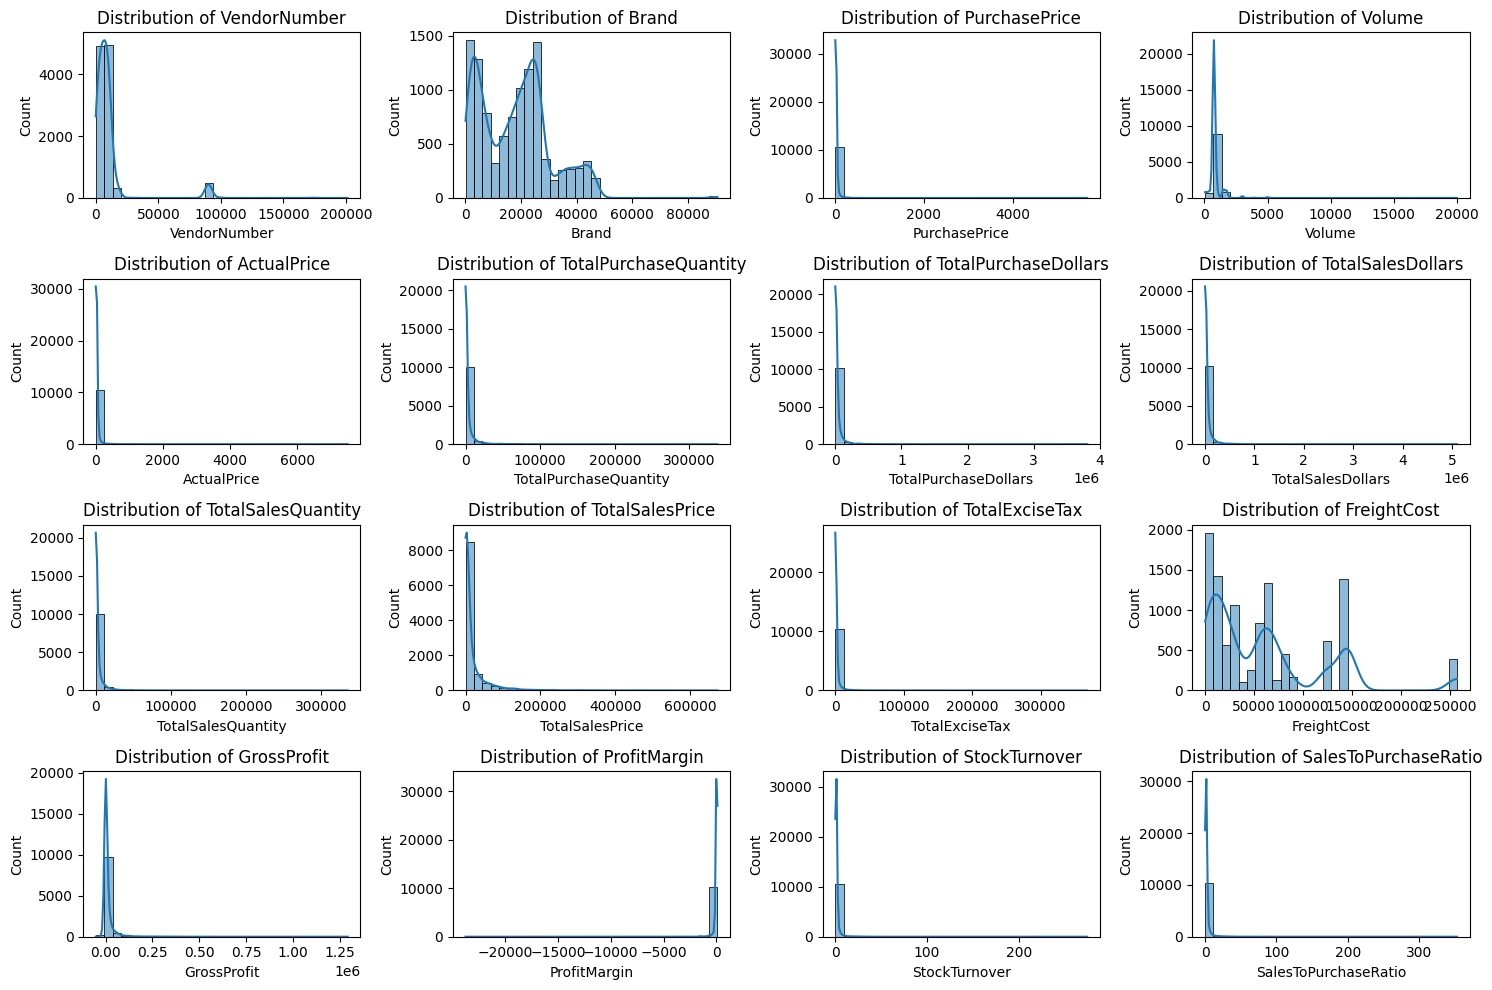

In [18]:
# to check for outliers
# Distribution plots for numerical columns

numerical_columns = df.select_dtypes(include=np.number).columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns):
    plt.subplot(4, 4, i+1) # grid of 4 rows and 4 columns
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

**Top 5 Variables with Strong Outlier Influence:**
1. ProfitMargin – Contains -inf, massive negative values → likely due to division by zero.

2. TotalPurchaseQuantity – Goes up to 3.37 lakh while 75% are under 2000 → high outliers.

3. GrossProfit – Negative values and extreme positive values > ₹10 lakh.

4. FreightCost – Multi-modal with outliers > ₹2.5 lakh → cost management issue, suggest logistics inefficiencies or bulk shipments.

5. TotalSalesDollars – A few extreme sales dominate; heavy right skew.

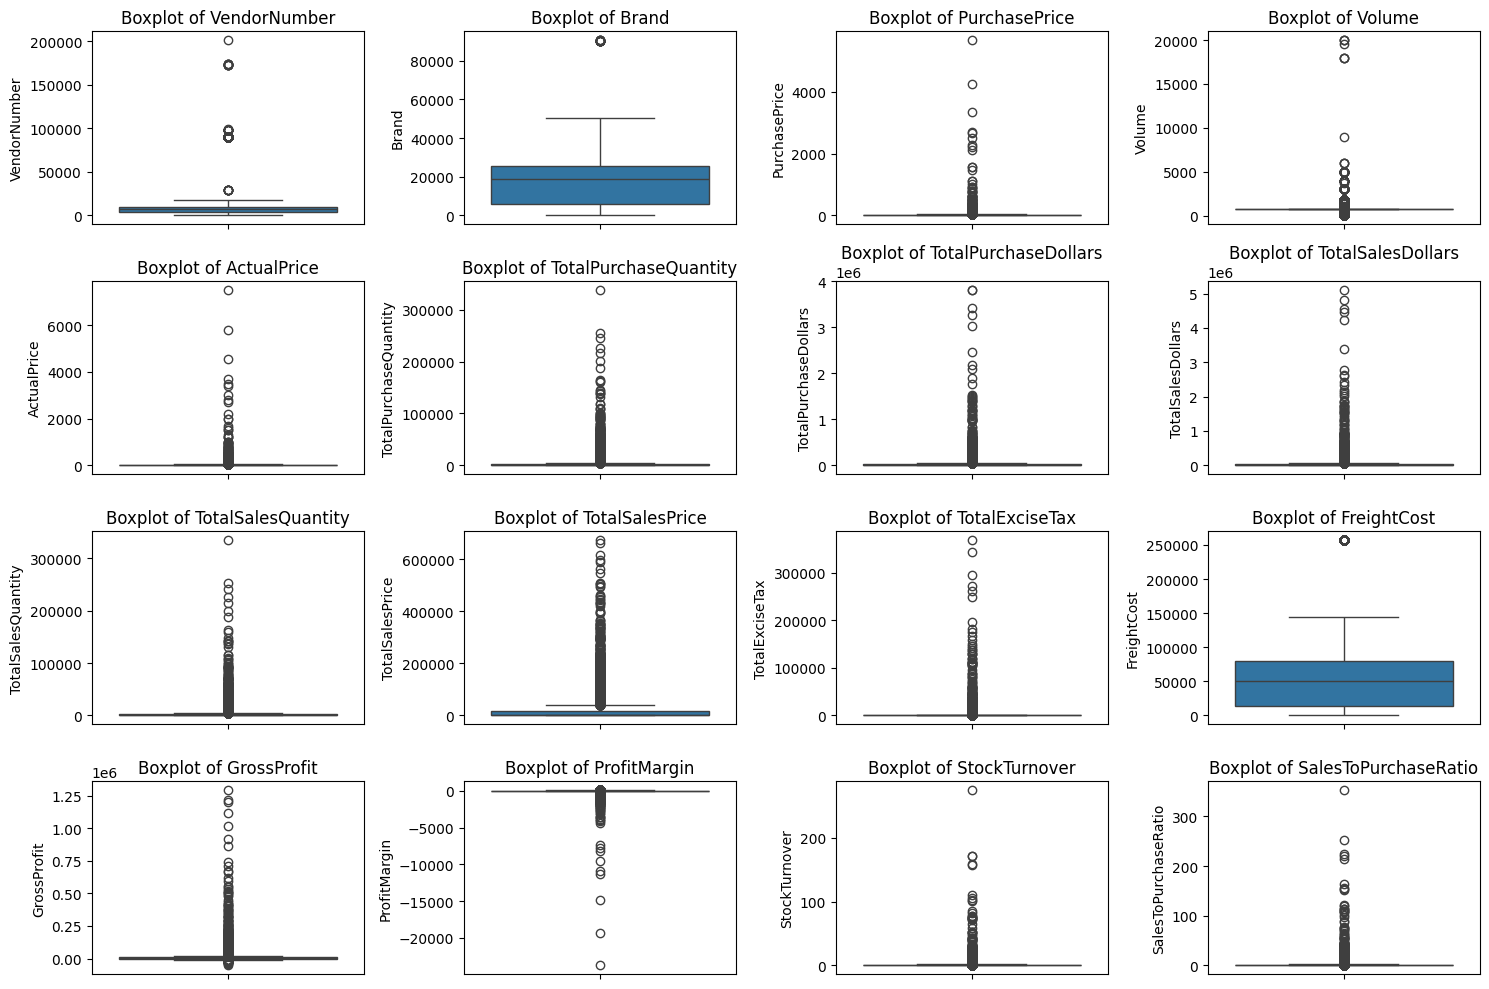

In [19]:
# box plot for outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns):
    plt.subplot(4, 4, i+1)
    sns.boxplot(df[col], orient='v')
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [20]:
# we will be filtering out the data where the value is 0 or less, in case of GrossProfit, ProfitMargin and TotalsalesQuantity.
df = pd.read_sql_query("""SELECT * 
FROM vendor_sales_summary
WHERE GrossProfit > 0 
AND ProfitMargin > 0 
AND TotalsalesQuantity > 0""", con)

In [21]:
df.shape

(8565, 18)

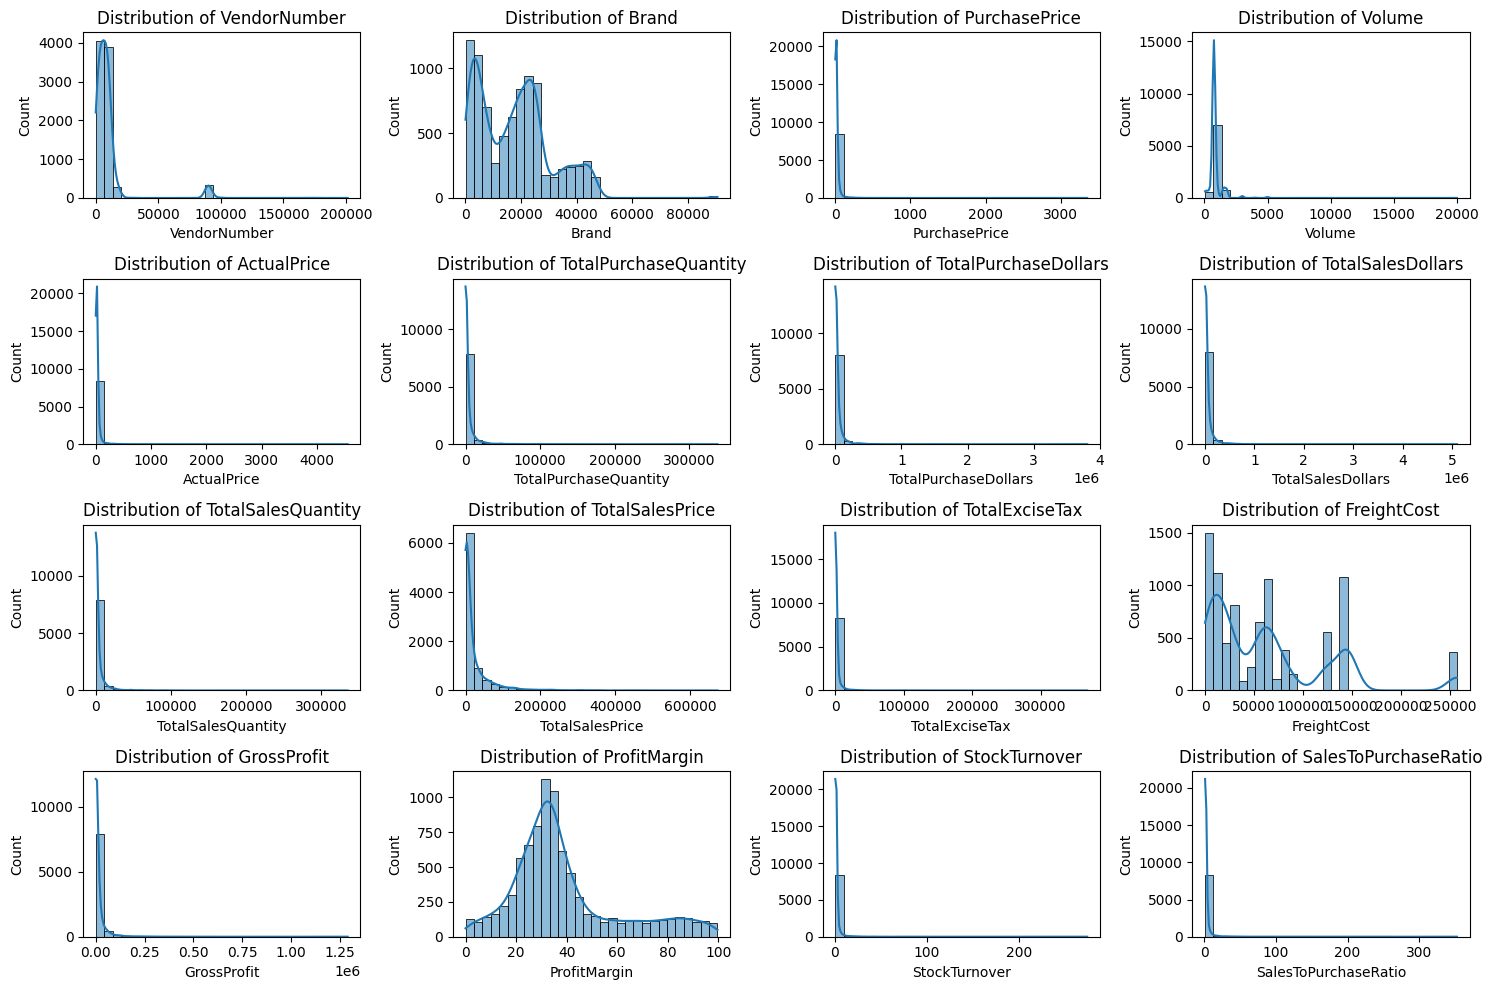

In [22]:
numerical_columns = df.select_dtypes(include=np.number).columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns):
    plt.subplot(4, 4, i+1) # grid of 4 rows and 4 columns
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

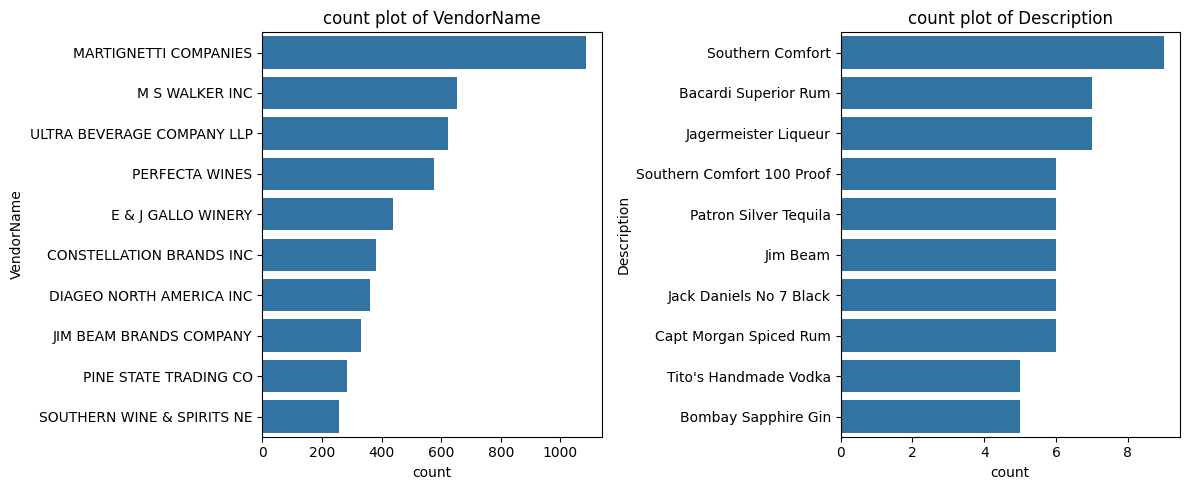

In [23]:
# Count plot for categorical columns
categorical_col = ["VendorName", "Description"]

plt.figure(figsize=(12, 5))
for i, col in enumerate(categorical_col):
    plt.subplot(1, 2, i+1) # grid of 1 row and 2 columns
    sns.countplot(y=df[col], order=df[col].value_counts().index[:10])
    plt.title(f'count plot of {col}') # top 10 categories
plt.tight_layout()
plt.show()

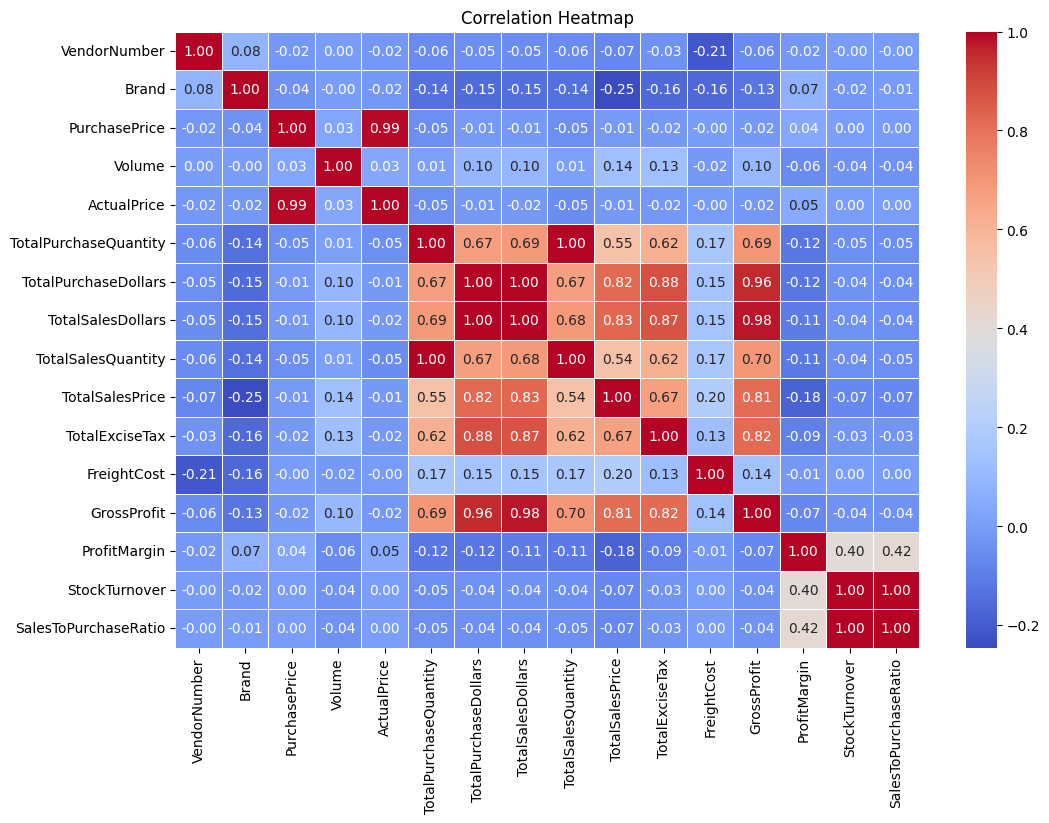

In [24]:
# heatmap for correlation
plt.figure(figsize=(12, 8))
corr = df[numerical_columns].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

**Correlation Insights**
1. PurchasePrice has a weak corr with TotalSalesDollars and Grossrofit, suggesting that price variations do not significantly impact sales revenue or profit.
2. Strong corr between purchase quantity and total sales quantity, confirming efficient inventory turnover. what’s purchased is mostly sold. Efficient stock usage.
3. Negative corr between profitmargin and total sales price suggests that as sales price increases, margin decreases, possibly due to competitive pricing pressure.
4. Stock Turnover has weak negative correlation with both grossprofit and profitmargin, indicating that faster turnover doesnt necesarrily result in high profitablity.


## DATA ANALYSIS

**1. Identify brands that need Promotional or Pricing adjustments which exhibit lower sales performance but higher profit margins.**

In [25]:
brand_performance = df.groupby('Description').agg({
    'TotalSalesDollars':'sum',
    'ProfitMargin':'mean'   # as it is in percentage
}).reset_index()

In [26]:
# calculating brand score
# we need to set a threshold for the brand score, for those who need a promotional campaign
low_sales_threshold = brand_performance['TotalSalesDollars'].quantile(0.15)
high_margin_threshold = brand_performance['ProfitMargin'].quantile(0.85)

In [27]:
low_sales_threshold

560.299

In [29]:
high_margin_threshold?

Type:        float64
String form: 64.97017552750111
File:        c:\users\hp\appdata\local\programs\python\python312\lib\site-packages\numpy\__init__.py
Docstring:  
Double-precision floating-point number type, compatible with Python `float`
and C ``double``.

:Character code: ``'d'``
:Canonical name: `numpy.double`
:Alias: `numpy.float_`
:Alias on this platform (win32 AMD64): `numpy.float64`: 64-bit precision floating-point number type: sign bit, 11 bits exponent, 52 bits mantissa.

In [31]:
# filtering brands with low sales but high profit margins
target_brands = brand_performance[
    (brand_performance['TotalSalesDollars'] <= low_sales_threshold) &
    (brand_performance['ProfitMargin'] >= high_margin_threshold)
]
print(f"Number of brands with low sales but high profit margins: {len(target_brands)}")
display(target_brands.sort_values('TotalSalesDollars'))

Number of brands with low sales but high profit margins: 198


,Description,TotalSalesDollars,ProfitMargin
6199,Santa Rita Organic Svgn Bl,9.99,66.466466
2369,Debauchery Pnt Nr,11.58,65.975820
2070,Concannon Glen Ellen Wh Zin,15.95,83.448276
2188,Crown Royal Apple,27.86,89.806174
6237,Sauza Sprklg Wild Berry Marg,27.96,82.153076
...,...,...,...
5074,Nanbu Bijin Southern Beauty,535.68,76.747312
2271,Dad's Hat Rye Whiskey,538.89,81.851584
57,A Bichot Clos Marechaudes,539.94,67.740860
6245,Sbragia Home Ranch Merlot,549.75,66.444748


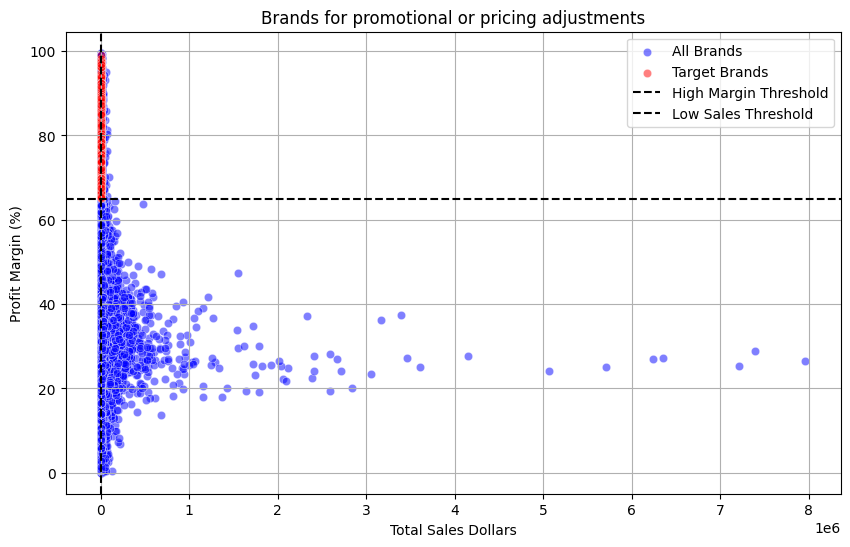

In [32]:
# scatter plot of sales vs profit margin
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalSalesDollars', y='ProfitMargin', data=brand_performance, alpha=0.5, color='blue', label='All Brands')
sns.scatterplot(x='TotalSalesDollars', y='ProfitMargin', data=target_brands, alpha=0.5, color='red', label='Target Brands')

plt.axhline(high_margin_threshold, color='black', linestyle='--', label='High Margin Threshold')
plt.axvline(low_sales_threshold, color='black', linestyle='--', label='Low Sales Threshold')

plt.title('Brands for promotional or pricing adjustments')
plt.xlabel('Total Sales Dollars')
plt.ylabel('Profit Margin (%)')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
brand_performance = brand_performance[brand_performance['TotalSalesDollars'] < 10000]
# for better visualization

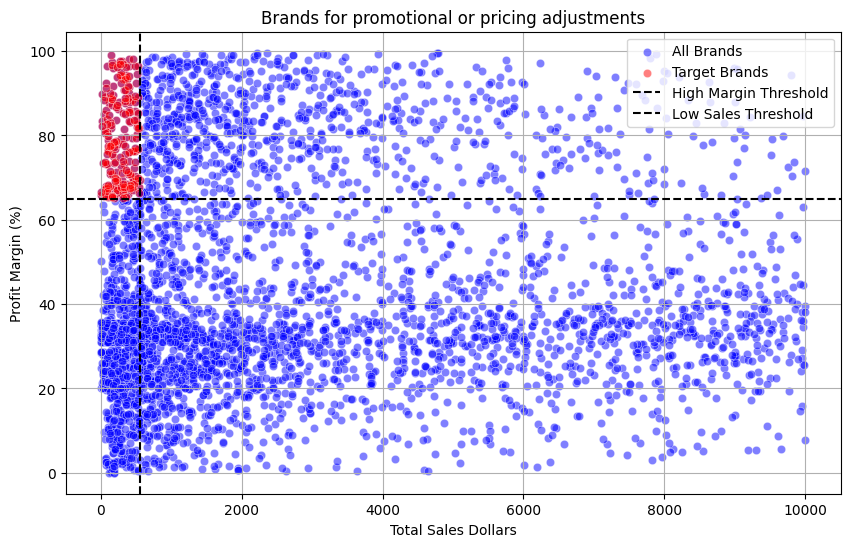

In [34]:
# scatter plot of sales vs profit margin
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalSalesDollars', y='ProfitMargin', data=brand_performance, alpha=0.5, color='blue', label='All Brands')
sns.scatterplot(x='TotalSalesDollars', y='ProfitMargin', data=target_brands, alpha=0.5, color='red', label='Target Brands')

plt.axhline(high_margin_threshold, color='black', linestyle='--', label='High Margin Threshold')
plt.axvline(low_sales_threshold, color='black', linestyle='--', label='Low Sales Threshold')

plt.title('Brands for promotional or pricing adjustments')
plt.xlabel('Total Sales Dollars')
plt.ylabel('Profit Margin (%)')
plt.legend()
plt.grid(True)
plt.show()

**2. Which vendor and brands demonstrate the hightes sales performance?**

In [35]:
# top vendors and brands by sales performance
top_vendors = df.groupby("VendorName")["TotalSalesDollars"].sum().nlargest(10)
top_brands = df.groupby("Description")["TotalSalesDollars"].sum().nlargest(10)


In [41]:
# function for formating
def format_dollars(value):
    if value >= 1_000_000:
        return f"{value/1_000_000:.2f}M"
    elif value >= 1_000:
        return f"{value/1_000:.2f}K"
    else:
        return str(value)

In [39]:
top_vendors

VendorName
DIAGEO NORTH AMERICA INC      6.799010e+07
MARTIGNETTI COMPANIES         3.933036e+07
PERNOD RICARD USA             3.206320e+07
JIM BEAM BRANDS COMPANY       3.142302e+07
BACARDI USA INC               2.485482e+07
CONSTELLATION BRANDS INC      2.421875e+07
E & J GALLO WINERY            1.839990e+07
BROWN-FORMAN CORP             1.824723e+07
ULTRA BEVERAGE COMPANY LLP    1.650254e+07
M S WALKER INC                1.470646e+07
Name: TotalSalesDollars, dtype: float64

In [37]:
top_brands

Description
Jack Daniels No 7 Black    7964746.76
Tito's Handmade Vodka      7399657.58
Grey Goose Vodka           7209608.06
Capt Morgan Spiced Rum     6356320.62
Absolut 80 Proof           6244752.03
Jameson Irish Whiskey      5715759.69
Ketel One Vodka            5070083.56
Baileys Irish Cream        4150122.07
Kahlua                     3604858.66
Tanqueray                  3456697.90
Name: TotalSalesDollars, dtype: float64

In [42]:
top_brands.apply(lambda x: format_dollars(x))

Description
Jack Daniels No 7 Black    7.96M
Tito's Handmade Vodka      7.40M
Grey Goose Vodka           7.21M
Capt Morgan Spiced Rum     6.36M
Absolut 80 Proof           6.24M
Jameson Irish Whiskey      5.72M
Ketel One Vodka            5.07M
Baileys Irish Cream        4.15M
Kahlua                     3.60M
Tanqueray                  3.46M
Name: TotalSalesDollars, dtype: object

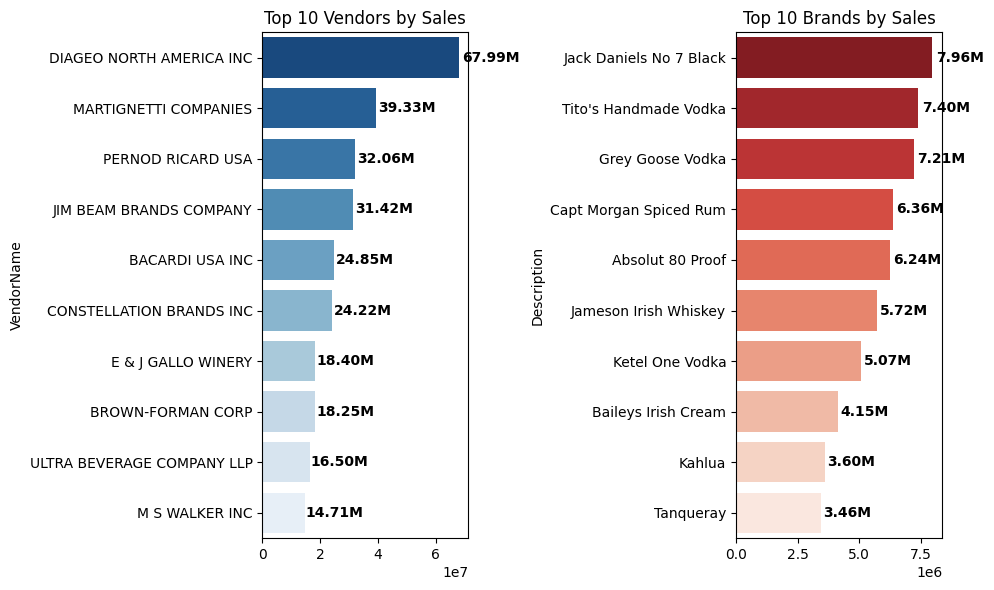

In [43]:
plt.figure(figsize=(10, 6))

# plot for top vendors
plt.subplot(1, 2, 1)
ax1 = sns.barplot(y=top_vendors.index, x=top_vendors.values, palette="Blues_r")
plt.title("Top 10 Vendors by Sales")

for bar in ax1.patches:
    ax1.text(bar.get_width() + (bar.get_width() * 0.02),
    bar.get_y() + bar.get_height() / 2,
    format_dollars(bar.get_width()),
    ha="left", va="center", fontsize=10, color="black", weight="bold")


# plot for top brands
plt.subplot(1, 2, 2)
ax2 = sns.barplot(y=top_brands.index.astype(str), x=top_brands.values, palette="Reds_r")
plt.title("Top 10 Brands by Sales")

for bar in ax2.patches:
    ax2.text(bar.get_width() + (bar.get_width() * 0.02),
    bar.get_y() + bar.get_height() / 2,
    format_dollars(bar.get_width()),
    ha="left", va="center", fontsize=10, color="black", weight="bold")


plt.tight_layout()
plt.show()

**3. which vendors contribute the most to total purchase dollars?**

In [47]:
vendor_contribution = df.groupby("VendorName").agg({
    "TotalPurchaseDollars": "sum",
    "GrossProfit": "sum",
    "TotalSalesDollars": "sum"
}).reset_index()

In [53]:
vendor_contribution['PurchaseContribution(%)'] = vendor_contribution['TotalPurchaseDollars'] / vendor_contribution['TotalPurchaseDollars'].sum()

In [57]:
vendor_contribution.drop(columns=["PurchaseContriPercentage"], inplace=True)

In [61]:
vendor_contribution = round(vendor_contribution.sort_values('PurchaseContribution(%)', ascending=False), 2)

In [62]:
vendor_contribution

,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,PurchaseContribution(%)
25,DIAGEO NORTH AMERICA INC,50097226.16,17892873.26,67990099.42,0.16
57,MARTIGNETTI COMPANIES,25502095.83,13828263.53,39330359.36,0.08
68,PERNOD RICARD USA,23851164.17,8212032.02,32063196.19,0.08
46,JIM BEAM BRANDS COMPANY,23494304.32,7928716.14,31423020.46,0.08
6,BACARDI USA INC,17432020.26,7422796.88,24854817.14,0.06
...,...,...,...,...,...
33,FANTASY FINE WINES CORP,128.64,198.95,327.59,0.00
107,UNCORKED,118.74,58.20,176.94,0.00
85,SILVER MOUNTAIN CIDERS,77.18,265.33,342.51,0.00
16,CAPSTONE INTERNATIONAL,54.64,192.23,246.87,0.00


In [63]:
# display top 10 vendors by total purchase dollars
top_vendors = vendor_contribution.head(10)
top_vendors['TotalSalesDollars'] = top_vendors['TotalSalesDollars'].apply(format_dollars)
top_vendors['TotalPurchaseDollars'] = top_vendors['TotalPurchaseDollars'].apply(format_dollars)
top_vendors['GrossProfit'] = top_vendors['GrossProfit'].apply(format_dollars)

top_vendors

,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,PurchaseContribution(%)
25,DIAGEO NORTH AMERICA INC,50.10M,17.89M,67.99M,0.16
57,MARTIGNETTI COMPANIES,25.50M,13.83M,39.33M,0.08
68,PERNOD RICARD USA,23.85M,8.21M,32.06M,0.08
46,JIM BEAM BRANDS COMPANY,23.49M,7.93M,31.42M,0.08
6,BACARDI USA INC,17.43M,7.42M,24.85M,0.06
20,CONSTELLATION BRANDS INC,15.27M,8.95M,24.22M,0.05
11,BROWN-FORMAN CORP,13.24M,5.01M,18.25M,0.04
30,E & J GALLO WINERY,12.07M,6.33M,18.40M,0.04
106,ULTRA BEVERAGE COMPANY LLP,11.17M,5.34M,16.50M,0.04
53,M S WALKER INC,9.76M,4.94M,14.71M,0.03


In [ ]:
# out of 119 vendors only 10 vendors are contributing nearly 66%
top_vendors['PurchaseContribution(%)'].sum()

0.6600000000000001